
=== GA Generation 1/6 ===
Evaluating individual 1/10: {'units': 118, 'num_layers': 1, 'dropout': 0.0917173949330819, 'lr': 0.00218309683905246, 'batch_size': 32, 'seq_len': 43}
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 -> val RMSE: 0.020371
Evaluating individual 2/10: {'units': 137, 'num_layers': 3, 'dropout': 0.04998745790900144, 'lr': 0.00023864188780056057, 'batch_size': 128, 'seq_len': 40}
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
 -> val RMSE: 0.039205
Evaluating individual 3/10: {'units': 119, 'num_layers': 3, 'dropout': 0.010292247147901223, 'lr': 0.008123245085588687, 'batch_size': 248, 'seq_len': 34}
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
 -> val RMSE: 0.050360
Evaluating individual 4/10: {'units': 53, 'num_layers': 2, 'dropout': 0.09091248360355031, 'lr': 3.5498788321965036e-05, 'batch_size': 216, 'seq_len': 26}
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
 -> val RMSE: 0.497830
Evaluating individual 5/10: {'units': 251, 'num_layers': 1, 'dropout': 0.14561457009902096, 'lr': 0.000684792009

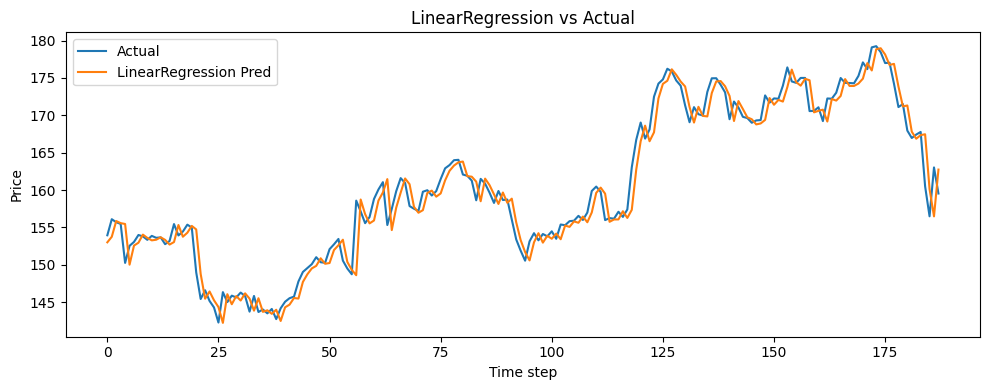

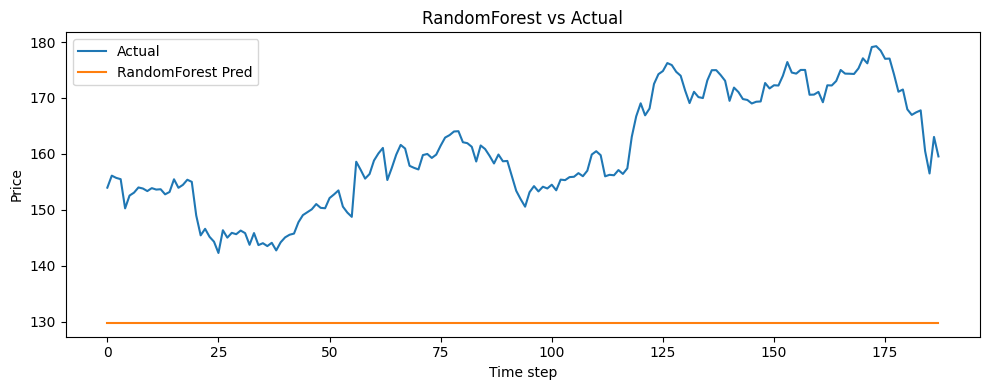

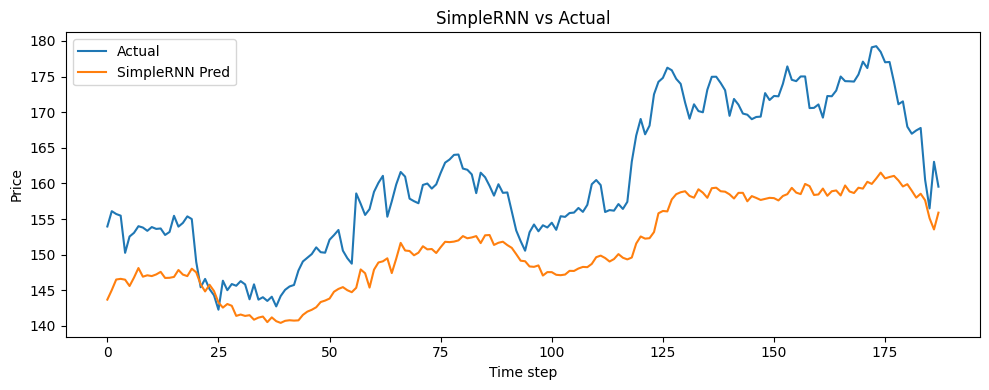

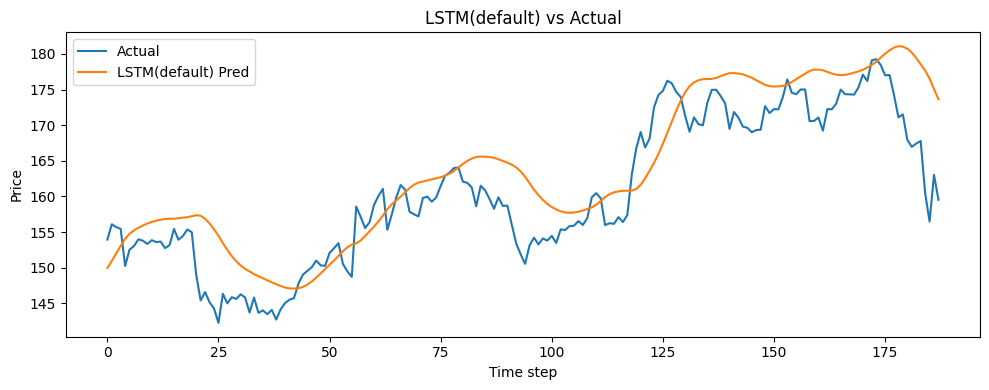

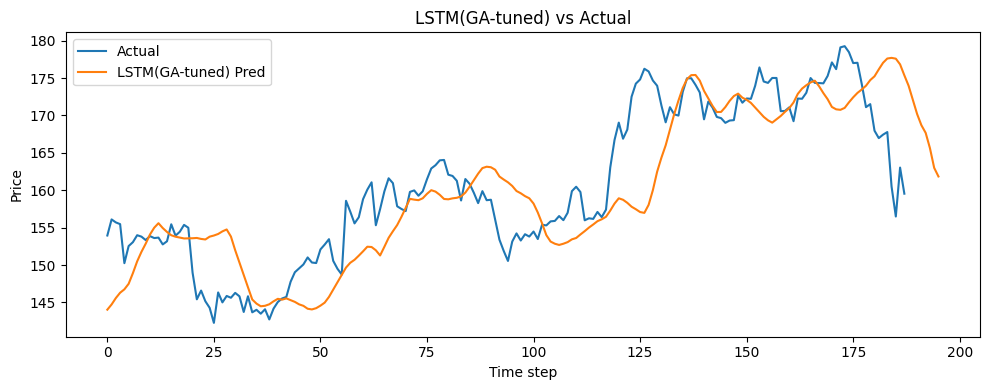


Experiment completed.


In [10]:
import argparse
import os
import random
import math
import warnings
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
warnings.filterwarnings("ignore")

def load_data(path: str, price_col: str = "Close", date_col: str = "Date") -> pd.DataFrame:
    df = pd.read_csv(path)
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values(date_col).reset_index(drop=True)
    if price_col not in df.columns:
        raise ValueError(f"Price column '{price_col}' not found.")
    df = df[[price_col]].dropna().reset_index(drop=True)
    df.columns = ["price"]
    return df

def create_sequences(series: np.ndarray, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i + seq_len])
        y.append(series[i + seq_len])
    return np.array(X), np.array(y)

def train_val_test_split(X, y, train_frac=0.7, val_frac=0.15):
    n = len(X)
    train_end = int(n * train_frac)
    val_end = train_end + int(n * val_frac)
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def build_simple_rnn(input_shape: Tuple[int, int], units=32, dropout=0.0, lr=1e-3):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

def build_lstm(input_shape: Tuple[int, int], units=50, num_layers=1, dropout=0.0, lr=1e-3):
    model = Sequential()
    if num_layers == 1:
        model.add(LSTM(units, input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))
    else:
        for i in range(num_layers):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(LSTM(units, return_sequences=return_seq, input_shape=input_shape))
            else:
                model.add(LSTM(units, return_sequences=return_seq))
            if dropout > 0:
                model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

def train_linear_regression(X_train_flat, y_train):
    lr = LinearRegression()
    lr.fit(X_train_flat, y_train)
    return lr

def train_random_forest(X_train_flat, y_train, n_estimators=100, max_depth=None):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=SEED, n_jobs=-1)
    rf.fit(X_train_flat, y_train)
    return rf

HYPERSPACE = {
    "units": (16, 256),           
    "num_layers": (1, 3),        
    "dropout": (0.0, 0.5),        
    "lr": (1e-5, 1e-2),           
    "batch_size": (16, 256),      
    "seq_len": (5, 60),          
}

def sample_random_individual():
    """Random initialize an individual in the hyperparameter space."""
    ind = {
        "units": int(np.random.randint(HYPERSPACE["units"][0], HYPERSPACE["units"][1] + 1)),
        "num_layers": int(np.random.randint(HYPERSPACE["num_layers"][0], HYPERSPACE["num_layers"][1] + 1)),
        "dropout": float(np.random.rand() * (HYPERSPACE["dropout"][1] - HYPERSPACE["dropout"][0]) + HYPERSPACE["dropout"][0]),
        "lr": float(10 ** np.random.uniform(math.log10(HYPERSPACE["lr"][0]), math.log10(HYPERSPACE["lr"][1]))),
        "batch_size": int(np.random.randint(HYPERSPACE["batch_size"][0], HYPERSPACE["batch_size"][1] + 1)),
        "seq_len": int(np.random.randint(HYPERSPACE["seq_len"][0], HYPERSPACE["seq_len"][1] + 1)),
    }
    ind["batch_size"] = max(8, (ind["batch_size"] // 8) * 8)
    return ind


def crossover(parent_a: Dict[str, Any], parent_b: Dict[str, Any]) -> Dict[str, Any]:
    child = {}
    for k in parent_a.keys():
        # uniform crossover
        child[k] = parent_a[k] if np.random.rand() < 0.5 else parent_b[k]
    return child


def mutate(ind: Dict[str, Any], mutation_rate=0.2, heavy_tail_prob=0.2, superjump_prob=0.02):
    new = dict(ind)
    for k, (low, high) in HYPERSPACE.items():
        if np.random.rand() < mutation_rate:
            if np.random.rand() < superjump_prob:
                new[k] = sample_random_individual()[k]
                continue
            if np.random.rand() < heavy_tail_prob:
                scale = (high - low) * 0.1
                delta = np.random.standard_cauchy() * scale
            else:
                scale = (high - low) * 0.05
                delta = np.random.normal(scale=scale)
            current = float(new[k])
            mutated = current + delta
            if isinstance(low, int) and isinstance(high, int):
                mutated = int(np.round(mutated))
                mutated = max(low, min(high, mutated))
            else:
                mutated = float(mutated)
                mutated = max(low, min(high, mutated))
            new[k] = mutated
    new["units"] = int(max(HYPERSPACE["units"][0], min(HYPERSPACE["units"][1], int(round(new["units"])))))
    new["num_layers"] = int(max(HYPERSPACE["num_layers"][0], min(HYPERSPACE["num_layers"][1], int(round(new["num_layers"])))))
    new["seq_len"] = int(max(HYPERSPACE["seq_len"][0], min(HYPERSPACE["seq_len"][1], int(round(new["seq_len"])))))
    new["batch_size"] = int(max(8, (int(round(new["batch_size"])) // 8) * 8))
    new["dropout"] = float(max(HYPERSPACE["dropout"][0], min(HYPERSPACE["dropout"][1], float(new["dropout"]))))
    new["lr"] = float(max(HYPERSPACE["lr"][0], min(HYPERSPACE["lr"][1], float(new["lr"]))))
    return new

def tournament_selection(population, fitnesses, tournament_size=3):
    idxs = np.random.choice(len(population), size=tournament_size, replace=False)
    selected = idxs[np.argmin([fitnesses[i] for i in idxs])]  # lower fitness better (RMSE)
    return population[selected]

def evaluate_individual(individual, data_prices, scaler, train_frac=0.7, val_frac=0.15,
                        epochs=15, patience=3, verbose=0):
    
    seq_len = individual["seq_len"]
    series = scaler.transform(data_prices.reshape(-1, 1)).flatten()
    X, y = create_sequences(series, seq_len)
    if len(X) < 50:
        return 1e6, None

    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_frac, val_frac)

    # reshape for Keras: (samples, timesteps, features)
    X_train_r = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val_r = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    model = build_lstm(input_shape=(seq_len, 1),
                       units=individual["units"],
                       num_layers=individual["num_layers"],
                       dropout=individual["dropout"],
                       lr=individual["lr"])
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    try:
        history = model.fit(
            X_train_r, y_train,
            validation_data=(X_val_r, y_val),
            epochs=epochs,
            batch_size=individual["batch_size"],
            callbacks=[early],
            verbose=verbose
        )
    except Exception as e:
        print(f"Training failed for individual {individual}: {e}")
        return 1e6, None

    val_pred = model.predict(X_val_r).flatten()
    val_rmse = rmse(y_val, val_pred)
    return val_rmse, model


def run_genetic_algorithm(data_prices: np.ndarray,
                          scaler,
                          pop_size=12,
                          generations=8,
                          elitism_k=2,
                          tournament_size=3,
                          mutation_rate=0.25,
                          heavy_tail_prob=0.25,
                          superjump_prob=0.02,
                          random_injection_prob=0.05,
                          eval_epochs=12,
                          patience=3,
                          verbose_eval=0):

    population = [sample_random_individual() for _ in range(pop_size)]
    fitnesses = [None] * pop_size
    models = [None] * pop_size

    history_log = []

    for gen in range(generations):
        print(f"\n=== GA Generation {gen+1}/{generations} ===")
        for i, ind in enumerate(population):
            if fitnesses[i] is None:
                print(f"Evaluating individual {i+1}/{len(population)}: {ind}")
                fitness, model = evaluate_individual(ind, data_prices, scaler,
                                                     epochs=eval_epochs, patience=patience, verbose=verbose_eval)
                fitnesses[i] = fitness
                models[i] = model
                print(f" -> val RMSE: {fitness:.6f}")

        sorted_idx = np.argsort(fitnesses)
        best_idx = sorted_idx[0]
        best_fitness = fitnesses[best_idx]
        best_ind = population[best_idx]
        print(f"Generation {gen+1} best RMSE: {best_fitness:.6f} with {best_ind}")
        history_log.append((gen, best_fitness, best_ind))

        new_population = [population[idx] for idx in sorted_idx[:elitism_k]]
        new_models = [models[idx] for idx in sorted_idx[:elitism_k]]
        new_fitnesses = [fitnesses[idx] for idx in sorted_idx[:elitism_k]]

        while len(new_population) < pop_size:
            # Random injection
            if np.random.rand() < random_injection_prob:
                new_population.append(sample_random_individual())
                new_fitnesses.append(None)
                new_models.append(None)
                continue

            parent_a = tournament_selection(population, fitnesses, tournament_size)
            parent_b = tournament_selection(population, fitnesses, tournament_size)
            child = crossover(parent_a, parent_b)
            # Mutate
            child = mutate(child, mutation_rate=mutation_rate,
                           heavy_tail_prob=heavy_tail_prob, superjump_prob=superjump_prob)
            new_population.append(child)
            new_fitnesses.append(None)
            new_models.append(None)

        population = new_population
        fitnesses = new_fitnesses
        models = new_models

    for i, ind in enumerate(population):
        if fitnesses[i] is None:
            print(f"Final eval for individual {i+1}/{len(population)}: {ind}")
            fitness, model = evaluate_individual(ind, data_prices, scaler, epochs=eval_epochs, patience=patience, verbose=verbose_eval)
            fitnesses[i] = fitness
            models[i] = model
            print(f" -> val RMSE: {fitness:.6f}")

    sorted_idx = np.argsort(fitnesses)
    best_idx = sorted_idx[0]
    return population[best_idx], fitnesses[best_idx], models[best_idx], history_log

def run_experiment(csv_path: str, price_col: str = "Close", results_dir="results", run_ga: bool = True):
    import os
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    import tensorflow as tf

    os.makedirs(results_dir, exist_ok=True)
    
    df = load_data(csv_path, price_col=price_col)
    prices = df['price'].values.astype(float)

    mm_scaler = MinMaxScaler()
    prices_mm = mm_scaler.fit_transform(prices.reshape(-1, 1)).flatten()

    baseline_seq_len = 10
    X_mm_full, y_mm_full = create_sequences(prices_mm, baseline_seq_len)
    X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b = train_val_test_split(X_mm_full, y_mm_full)
    X_train_flat = X_train_b.reshape((X_train_b.shape[0], baseline_seq_len))
    X_val_flat = X_val_b.reshape((X_val_b.shape[0], baseline_seq_len))
    X_test_flat = X_test_b.reshape((X_test_b.shape[0], baseline_seq_len))

    lr_model = train_linear_regression(X_train_flat, y_train_b)
    rf_model = train_random_forest(X_train_flat, y_train_b, n_estimators=200, max_depth=10)
    rnn = build_simple_rnn(input_shape=(baseline_seq_len,1), units=32, dropout=0.1)
    rnn.fit(X_train_b.reshape((X_train_b.shape[0], baseline_seq_len,1)), y_train_b,
            validation_data=(X_val_b.reshape((X_val_b.shape[0], baseline_seq_len,1)), y_val_b),
            epochs=15, batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=0)

    lstm_default = {"units":64, "num_layers":1, "dropout":0.1, "lr":1e-3, "batch_size":32, "seq_len":20}
    seq_len_def = lstm_default["seq_len"]
    X_mm_def, y_mm_def = create_sequences(prices_mm, seq_len_def)
    X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = train_val_test_split(X_mm_def, y_mm_def)

    lstm_model = build_lstm(input_shape=(seq_len_def,1),
                            units=lstm_default["units"],
                            num_layers=lstm_default["num_layers"],
                            dropout=lstm_default["dropout"],
                            lr=lstm_default["lr"])
    lstm_model.fit(X_train_d.reshape((X_train_d.shape[0], seq_len_def,1)), y_train_d,
                   validation_data=(X_val_d.reshape((X_val_d.shape[0], seq_len_def,1)), y_val_d),
                   epochs=20, batch_size=lstm_default["batch_size"],
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)],
                   verbose=0)

    best_model = None
    best_individual = None
    if run_ga:
        best_individual, best_fitness, best_model, _ = run_genetic_algorithm(prices.reshape(-1,1), mm_scaler,
                                                                             pop_size=10, generations=6)

    def inv_scale(y_scaled): 
        return mm_scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()

    lr_test_pred = lr_model.predict(X_test_flat)
    rf_test_pred = rf_model.predict(X_test_flat)
    rnn_test_pred = rnn.predict(X_test_b.reshape((X_test_b.shape[0], baseline_seq_len,1))).flatten()

    lstm_X_test_aligned, _ = create_sequences(prices_mm, seq_len_def)
    X_test_lstm = lstm_X_test_aligned[-len(X_test_b):].reshape((-1, seq_len_def,1))
    y_test_lstm = y_mm_def[-len(y_test_b):]
    lstm_test_pred = lstm_model.predict(X_test_lstm).flatten()

    if best_model is not None:
        seq_len_ga = best_individual["seq_len"]
        # Proper alignment with baseline test start index
        test_start_idx = len(prices_mm) - len(X_test_b) - baseline_seq_len + 1
        test_end_idx = len(prices_mm)
        prices_test_window = prices_mm[test_start_idx - seq_len_ga + 1 : test_end_idx]
        X_test_ga, y_test_ga = create_sequences(prices_test_window, seq_len_ga)
        X_test_ga = X_test_ga.reshape((-1, seq_len_ga, 1))
        pred_test = best_model.predict(X_test_ga).flatten()
        test_rmse = rmse(inv_scale(y_test_ga), inv_scale(pred_test))
        test_mae = mae(inv_scale(y_test_ga), inv_scale(pred_test))
    else:
        pred_test = None
        test_rmse = None
        test_mae = None

    metrics = {
        "LinearRegression": (rmse(inv_scale(y_test_b), inv_scale(lr_test_pred)), mae(inv_scale(y_test_b), inv_scale(lr_test_pred))),
        "RandomForest": (rmse(inv_scale(y_test_b), inv_scale(rf_test_pred)), mae(inv_scale(y_test_b), inv_scale(rf_test_pred))),
        "SimpleRNN": (rmse(inv_scale(y_test_b), inv_scale(rnn_test_pred)), mae(inv_scale(y_test_b), inv_scale(rnn_test_pred))),
        "LSTM(default)": (rmse(inv_scale(y_test_lstm), inv_scale(lstm_test_pred)), mae(inv_scale(y_test_lstm), inv_scale(lstm_test_pred))),
        "LSTM(GA-tuned)": (test_rmse, test_mae)
    }

    summary_df = pd.DataFrame({
        "Model": list(metrics.keys()),
        "Test_RMSE": [m[0] for m in metrics.values()],
        "Test_MAE": [m[1] for m in metrics.values()]
    })
    print(summary_df)
    summary_df.to_csv(os.path.join(results_dir,"summary_metrics.csv"), index=False)

    for model_name, y_pred in zip(summary_df['Model'], [lr_test_pred, rf_test_pred, rnn_test_pred, lstm_test_pred, pred_test]):
        if y_pred is not None:
            plt.figure(figsize=(10,4))
            plt.plot(inv_scale(y_test_b), label="Actual")
            plt.plot(inv_scale(y_pred), label=f"{model_name} Pred")
            plt.title(f"{model_name} vs Actual")
            plt.xlabel("Time step")
            plt.ylabel("Price")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return summary_df, best_individual, best_model


if __name__ == "__main__":
    data_path = "/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/AAPL_data.csv"
    price_col = "close"
    results_dir = "results"
    run_ga_flag = True

    summary_df, best_ind, best_model = run_experiment(data_path, price_col, results_dir, run_ga_flag)
    print("\nExperiment completed.")

